# Patriot1 Assignment by Diogo Dutra

May 31st, 2019.

## Statement
Given the attached dataset, classify the two classes based on their similarities and then test the classifier on the Test set.

Dataset:

- contains two classes (class1 and class 2) as well as a Test set

- each data sample is a 1D signal containing 2400 points

 

Expected Results:

- What is the similarity metric used?

- What are the labels (Class1 or Class2) for the samples in the Test set?

- The developed codes

## Abstract

80%

## Introduction

The dataset has been extensively explored to understand its characteristics as every Machine Learning work must.

However, during this process many of the plots and comments are not directly applied to go directly from the problem statement to the proposed solution. For this reason, such material is kept in different files called Drafts that come altogether with the present file. They are not organized neither prepared for reading just like a sketchbook is not meant to be displayed in art galleries.

On the other hand, the present document details all the chain of thought that leads directly from the dataset to the predictions. For this reason, most of the observations obtained from the Drafts are not present as these do not contribute to achieve the final predictive model.

The present document is divided by following sections:
- Explore Dataset
- Prepare Dataset
- Create Model
- Evaluate Model
- Predict Test

## Explore Dataset

### Import libraries

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import scipy.fftpack
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score

%matplotlib inline

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Load Dataset

In [2]:
dataset = pd.DataFrame()


path = './Class1/'

df_class1 = []

for i, filename in enumerate(glob.glob(os.path.join(path, '*.npy'))):
    df_class1.append(np.load(filename))
    dataset.loc[i, 'Class'] = '1' #defining label
    
    

path = './Class2/'

df_class2 = []
rows_class1 = len(df_class1)

for i, filename in enumerate(glob.glob(os.path.join(path, '*.npy'))):
    df_class2.append(np.load(filename))
    dataset.loc[i + rows_class1, 'Class'] = '2' #defining label
    
    
    
raw = df_class1 + df_class2

### Plots

There is no clue in the statement regarding the source or type of the signal neither the classification meaning. Let's do some basic descriptive exploring as we have no clue yet.

In [3]:
print("Class1 first file is of type: ", type(df_class1))

Class1 first file is of type:  <class 'list'>


In [4]:
print("Class1 first file is a list of length: ", len(df_class1))

Class1 first file is a list of length:  24


So it is a list... of what?

In [5]:
display(raw[0])

array([-4.55315829e-07,  1.38722018e-06,  1.26157188e-06, ...,
       -5.05451959e-06, -4.28239176e-06, -2.77187002e-06])

In [6]:
print("Signal #0 is a list of one single array of shape: ", raw[0].shape)

Signal #0 is a list of one single array of shape:  (2400,)


In [7]:
print('Occurrences of NaN in signal #0 : ', np.isnan(raw[0]).sum())

Occurrences of NaN in signal #0 :  0


1-D array is usually a signal or a sound. Let's try the former option.

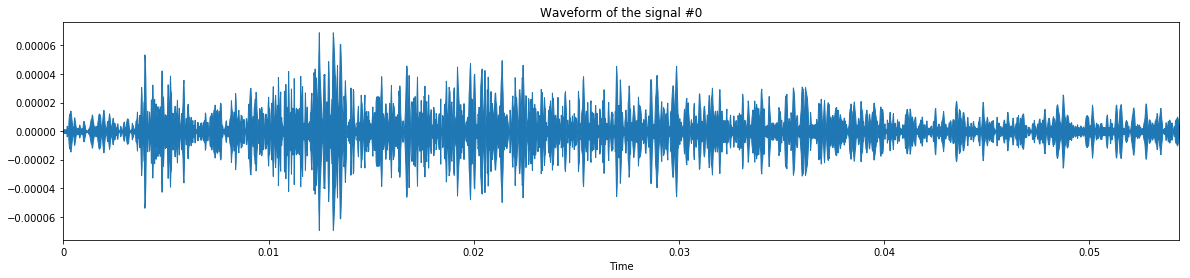

In [8]:
plt.figure(figsize=(20, 4))
fs = 44100
librosa.display.waveplot(raw[0], sr=fs)
plt.title('Waveform of the signal #0')
plt.show()

It looks like a sound indeed.

Let's plot them superimposed but separated by classes as if we are redrawing on over the other with a smooth pencil.

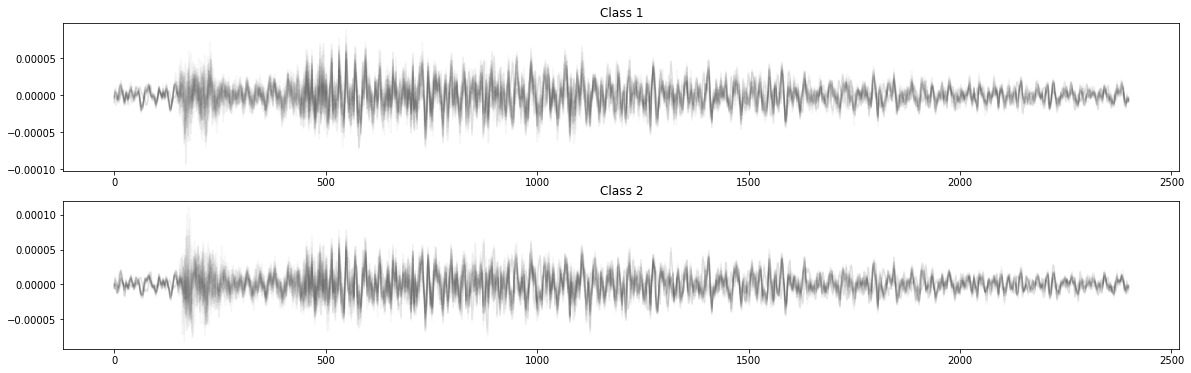

In [9]:
plt.figure(num=None, figsize=(20, 6))

alpha=0.03
index = range(0, 2400)
           
plt.subplot(2,1,1)
for i, arr in enumerate(df_class1):
    plt.plot(arr[index], alpha=alpha, c='k')
    plt.title('Class 1')
           
plt.subplot(2,1,2)
for i, arr in enumerate(df_class2):
    plt.plot(arr[index], alpha=alpha, c='k')
    plt.title('Class 2')
    
plt.show()

The two classes do look very similar, but nonetheless we can spot some small differences.

Let's zoom in to enhance the differences.

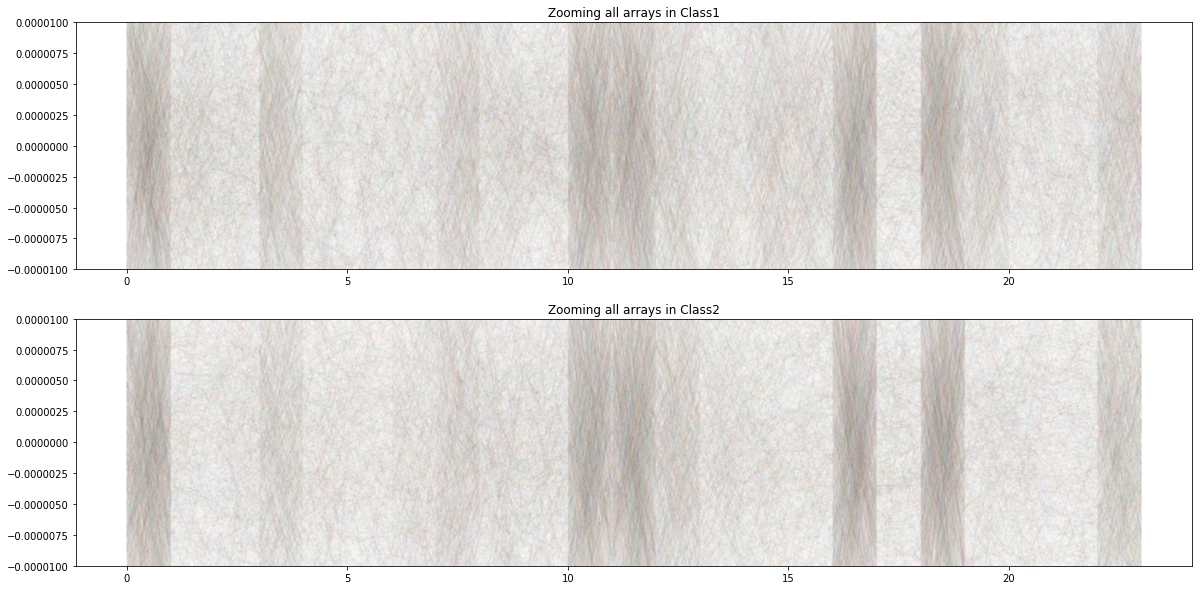

In [10]:
plt.figure(num=None, figsize=(20, 10))

y_lims = .00001
alpha = 0.01

plt.subplot(2,1,1)
plt.plot(df_class1, alpha=alpha)
plt.title('Zooming all arrays in Class1')
plt.ylim((-y_lims, y_lims))

plt.subplot(2,1,2)
plt.plot(df_class2, alpha=alpha)
plt.title('Zooming all arrays in Class2')
plt.ylim((-y_lims, y_lims))
    
plt.show()

The difference between the Class1 and Class2 are more noticeable in some vertical stripes spread over. The more remarkable are in the table below:

|          |    3 to 4   |  7 to 8   |  16 to 17 |  18 to 19 |  19 to 20 |  23 to 24 |
|----------|:-----------:|----------:|----------:|----------:|----------:|----------:|
|  Class1  |   darker    |   darker  |   lighter |   lighter |   darker  |   lighter |
|  Class2  |    lighter  |   lighter |   darker  |   darker  |   lighter |   darker  |

The darkness of the stripes are generated from high numeric derivative data (higher frequencies). 

### Finding Features

Let's apply Fast Fourier Transform for every stripe in the table above in order to extract useful features.

In [11]:
def plot_fft(index_begin=0, index_final=df_class1[0].shape[0], alpha=0.1, c='k'):
    plt.figure(num=None, figsize=(16, 14))
    
    y_max = 0

    N = index_final - index_begin

    plt.subplot(2,1,1)
    plt.title('FFT of range from ' + str(index_begin) + ' to ' + str(index_final) + ' in all arrays in Class1')
    for signal in df_class1:
        fft = scipy.fftpack.fft(signal[index_begin:index_final])
        y = np.abs(fft[:N//2])
        y_max = max(*y, y_max)
        plt.plot(y, alpha=alpha, c=c)
    
    plt.subplot(2,1,2)
    plt.title('FFT of range from ' + str(index_begin) + ' to ' + str(index_final) + ' in all arrays in Class2')
    for signal in df_class2:
        fft = scipy.fftpack.fft(signal[index_begin:index_final])
        y_max = max(*y, y_max)
        plt.plot(np.abs(fft[:N//2]), alpha=alpha, c=c)

    plt.subplot(2,1,1)
    plt.ylim((0, y_max))
    plt.xlabel('Frequency (Hz)')
    
    plt.subplot(2,1,2)
    plt.ylim((0, y_max))
    plt.xlabel('Frequency (Hz)')
    
    plt.show()

C:\Users\Diogo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


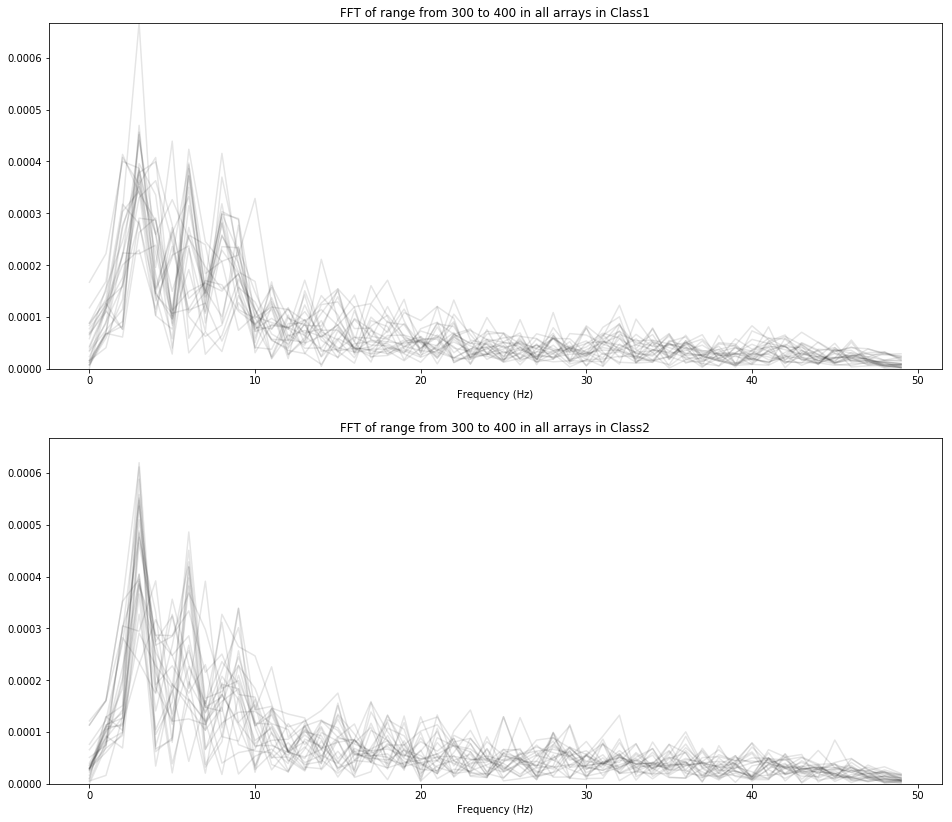

In [12]:
plot_fft(300, 400)

Let's add as a feature the intensity at 3Hz.

C:\Users\Diogo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


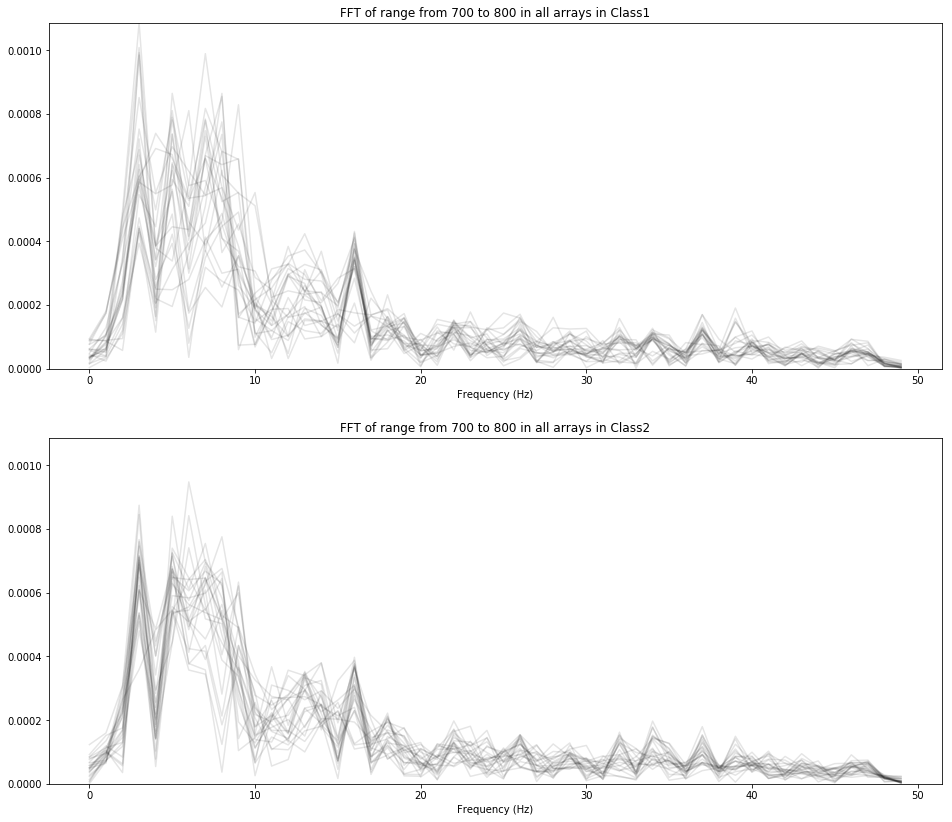

In [13]:
plot_fft(700, 800)

Let's add as features the intensities at 3Hz and 4Hz.

C:\Users\Diogo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


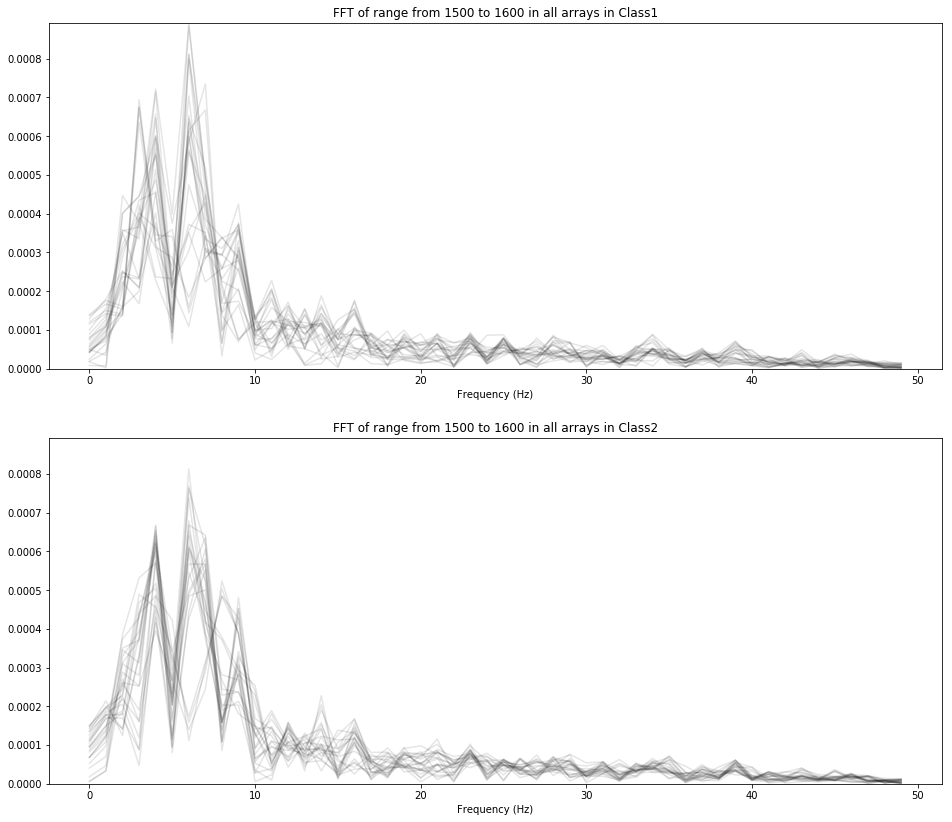

In [14]:
plot_fft(1500, 1600)

Let's add as a feature the intensity at 4Hz.

C:\Users\Diogo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


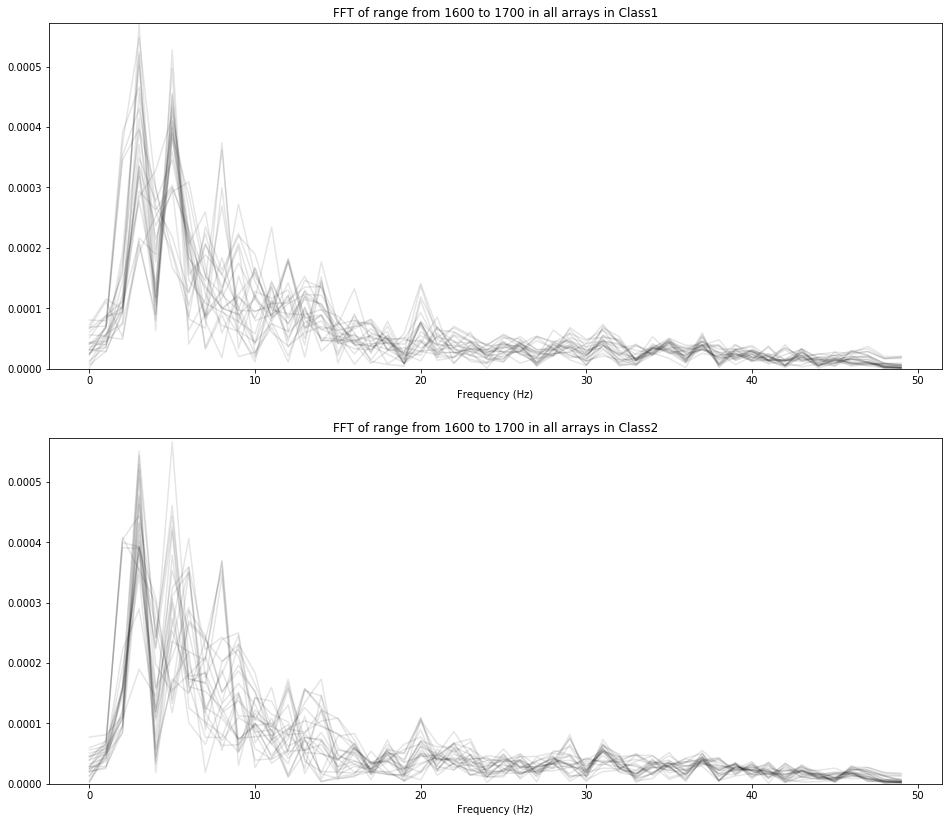

In [15]:
plot_fft(1600, 1700)

Let's add as features the intensities at 3Hz and 5Hz.

C:\Users\Diogo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


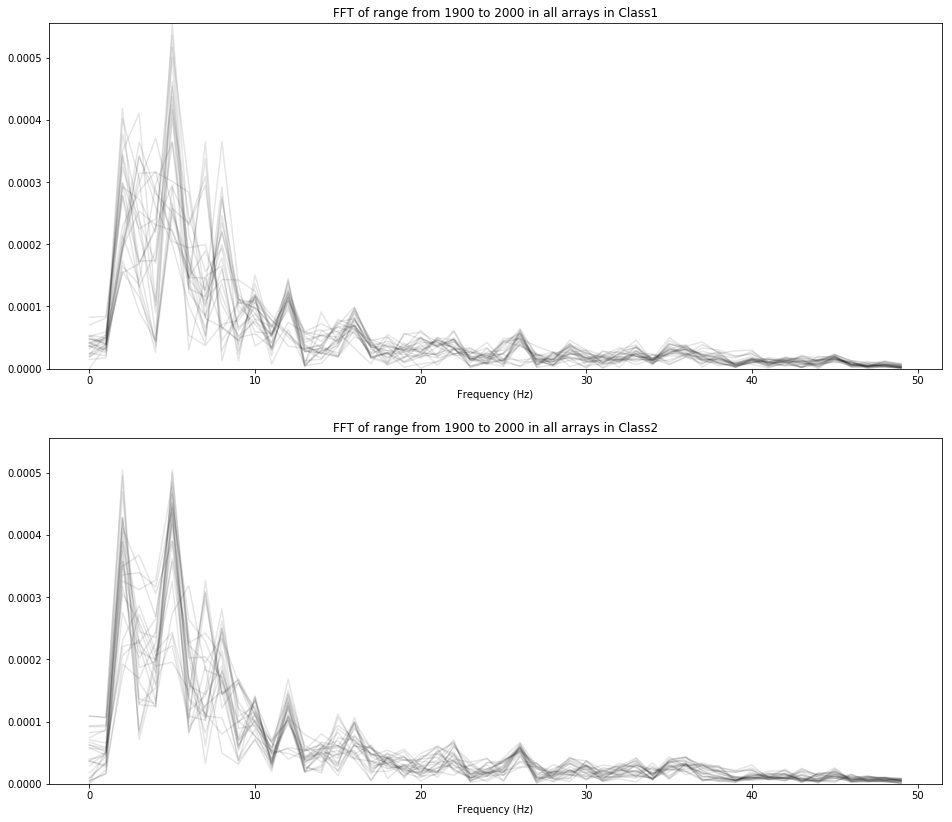

In [16]:
plot_fft(1900, 2000)

Let's add as features the intensities at 2Hz and 5Hz.

C:\Users\Diogo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


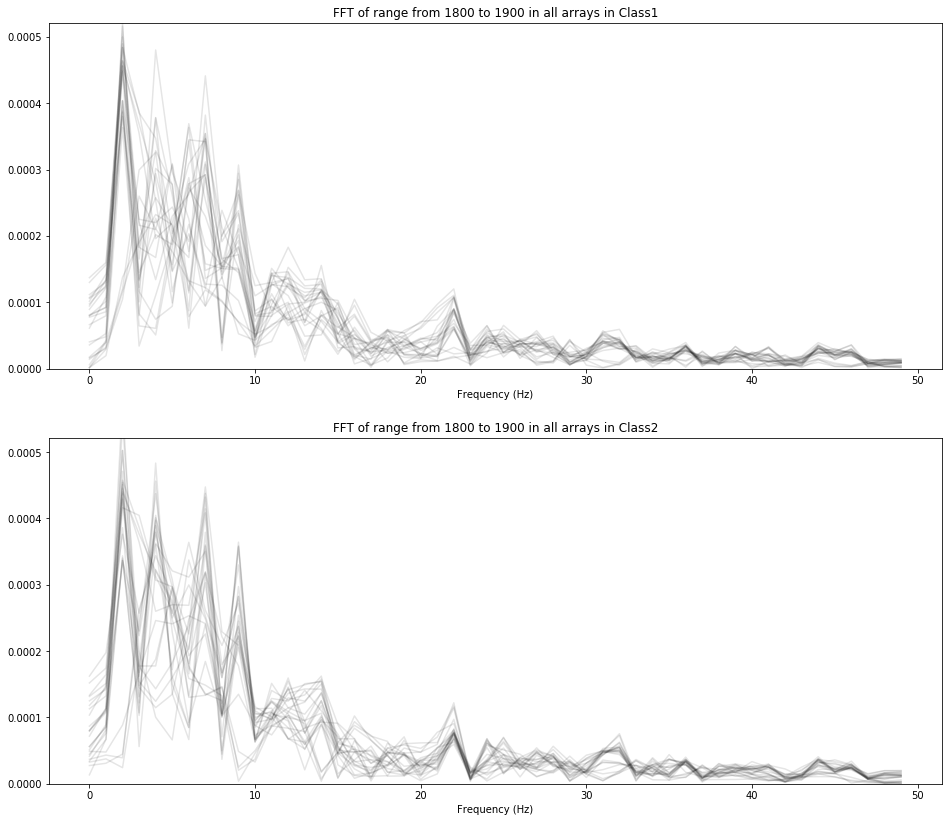

In [17]:
plot_fft(1800, 1900)

Let's add as features the intensities at 4Hz and 7Hz.

C:\Users\Diogo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


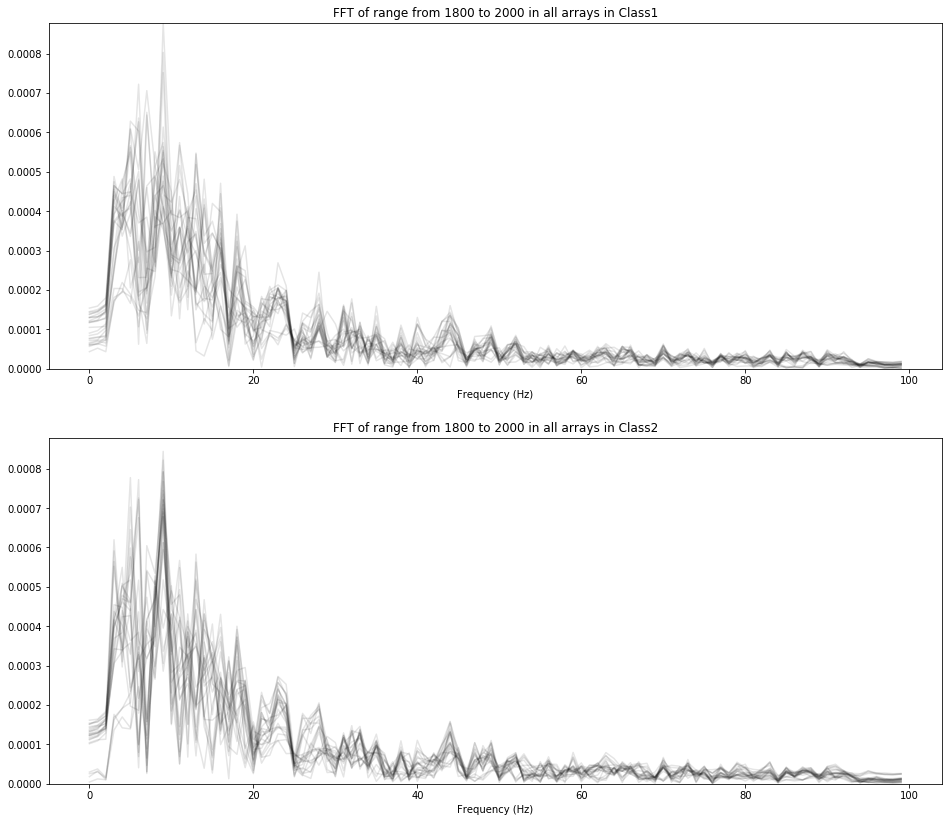

In [18]:
plot_fft(1800, 2000)

Let's add as a feature the intensity at 9Hz.

C:\Users\Diogo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


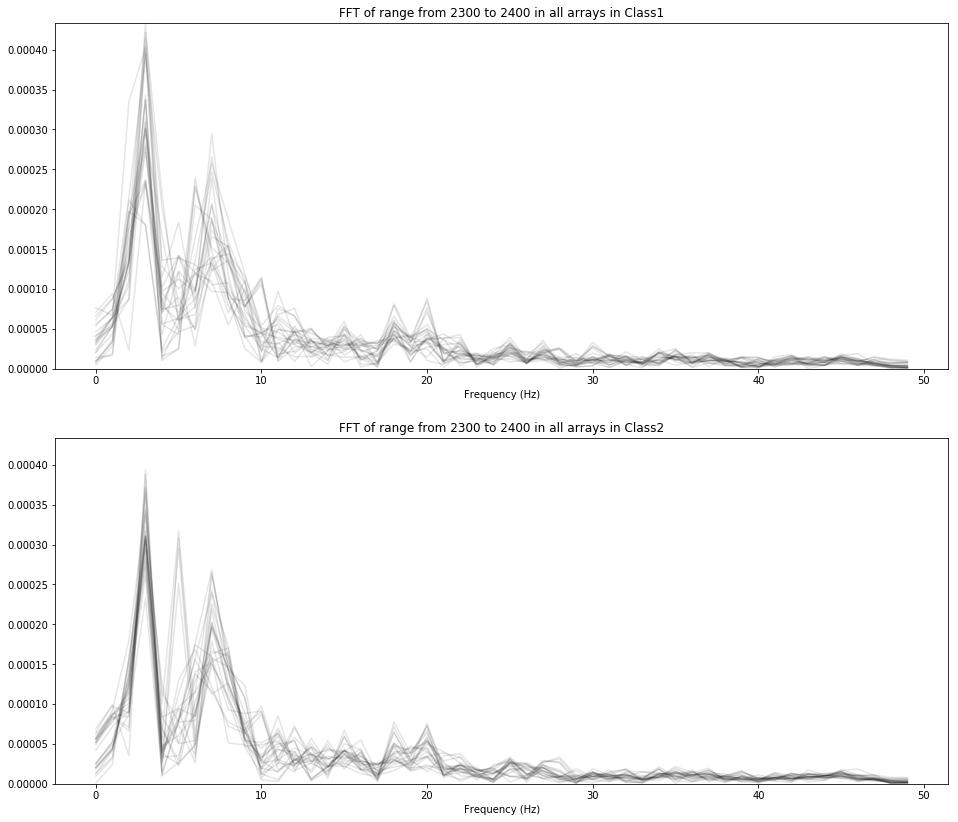

In [19]:
plot_fft(2300, 2400)

Let's add as a feature the intensity at 3Hz.

## Prepare Dataset

Add the previous features to the dataset.

In [20]:
def get_fft_intensity(dataset, list_signals, frequency, index_begin, index_final):
    feature_name = str(index_begin) + 'to' + str(index_final) + '_' + str(frequency) + 'Hz'
    for i, signal in enumerate(list_signals):
        fft = scipy.fftpack.fft(signal[index_begin:index_final])
        dataset.loc[i,feature_name] = np.abs(fft[frequency]) #defining label
        
    return dataset

In [21]:
def prepare_dataset(list_signals):
    dataset = pd.DataFrame()
    dataset = get_fft_intensity(dataset, list_signals, 3,  300,  400)
    dataset = get_fft_intensity(dataset, list_signals, 3,  700,  800)
    dataset = get_fft_intensity(dataset, list_signals, 4,  700,  800)
    dataset = get_fft_intensity(dataset, list_signals, 4, 1500, 1600)
    dataset = get_fft_intensity(dataset, list_signals, 3, 1600, 1700)
    dataset = get_fft_intensity(dataset, list_signals, 5, 1600, 1700)
    dataset = get_fft_intensity(dataset, list_signals, 4, 1800, 1900)
    dataset = get_fft_intensity(dataset, list_signals, 7, 1800, 1900)
    dataset = get_fft_intensity(dataset, list_signals, 2, 1900, 2000)
    dataset = get_fft_intensity(dataset, list_signals, 5, 1900, 2000)
    dataset = get_fft_intensity(dataset, list_signals, 9, 1800, 2000)
    dataset = get_fft_intensity(dataset, list_signals, 3, 2300, 2400)
    
    return dataset

In [22]:
dataset = pd.concat([dataset, prepare_dataset(raw)], axis=1)
dataset.head()

,Class,300to400_3Hz,700to800_3Hz,700to800_4Hz,1500to1600_4Hz,1600to1700_3Hz,1600to1700_5Hz,1800to1900_4Hz,1800to1900_7Hz,1900to2000_2Hz,1900to2000_5Hz,1800to2000_9Hz,2300to2400_3Hz
0,1,0.000291,0.000641,0.000341,0.000322,0.000396,0.000167,0.000232,0.000122,0.000165,0.000266,0.000439,0.000343
1,1,0.000285,0.000595,0.000281,0.000312,0.000327,0.000498,0.000220,0.000312,0.000194,0.000222,0.000550,0.000231
2,1,0.000364,0.000441,0.000250,0.000228,0.000211,0.000456,0.000168,0.000347,0.000198,0.000259,0.000574,0.000181
3,1,0.000330,0.000447,0.000205,0.000237,0.000205,0.000391,0.000210,0.000288,0.000229,0.000205,0.000533,0.000180
4,1,0.000351,0.000985,0.000151,0.000647,0.000524,0.000527,0.000302,0.000382,0.000377,0.000403,0.000752,0.000396


The added features do look like resourceful to differentiate between Class1 and Class2?

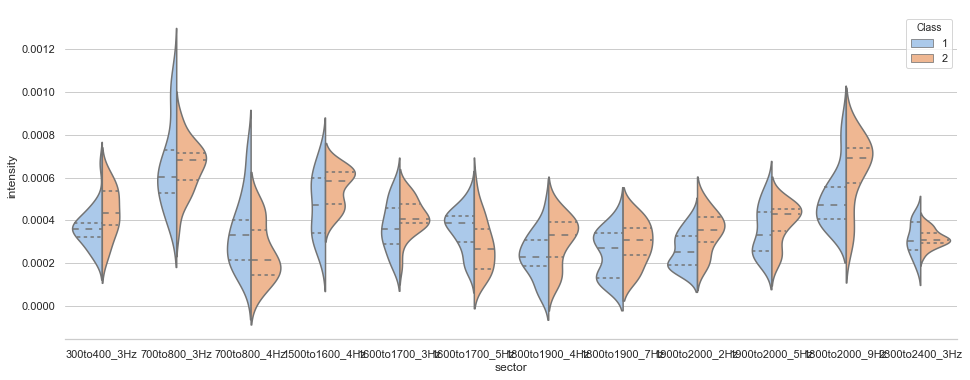

In [23]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
plt.figure(figsize=(16,6))

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x='sector', y='intensity', hue="Class",
               split=True, inner="quart",
               data=pd.melt(dataset, 'Class', var_name='sector', value_name='intensity'))
sns.despine(left=True)

The distributions of the considered feature values are different indeed. But some of them look like not of much help when trying to differenciate the classes.

Principal Component Analysis is being employed in order to reduce dimensions since we have only 48 samples in total.

In [24]:
target = 'Class'
x = dataset.drop(columns=[target]).values
pca = PCA()
principalComponents = pca.fit_transform(x)
dataset_pca = pd.DataFrame(data = principalComponents)
dataset_pca.columns = ['pc' + str(col) for col in dataset_pca.columns.tolist()]

dataset_pca = pd.concat([dataset_pca, dataset[[target]]], axis = 1)

print('Variance of each pca: ', pca.explained_variance_ratio_) 

dataset_pca.head()

Variance of each pca:  [0.29590713 0.19068072 0.16423475 0.08179644 0.06833489 0.05853895
 0.04689036 0.03785138 0.02617295 0.01641645 0.0069854  0.00619059]


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,Class
0,-0.000317,0.000015,-0.000096,-0.000113,-0.000024,4.597524e-05,-0.000112,-0.000068,0.000045,0.000006,-0.000019,0.000045,1
1,-0.000178,-0.000133,0.000083,-0.000144,0.000219,5.179503e-05,0.000003,0.000114,0.000004,0.000003,-0.000018,-0.000004,1
2,-0.000241,-0.000294,0.000126,-0.000061,0.000259,-2.850092e-05,0.000057,0.000039,0.000058,0.000027,0.000022,0.000034,1
3,-0.000292,-0.000279,0.000035,-0.000070,0.000221,3.587613e-07,0.000099,0.000016,0.000060,0.000017,-0.000010,-0.000007,1
4,0.000392,0.000125,-0.000096,-0.000032,0.000121,1.369747e-04,-0.000058,0.000227,-0.000006,-0.000016,-0.000045,-0.000006,1


Remove the last 5 features.

In [25]:
dataset_pca = dataset_pca.drop(columns=['pc7', 'pc8', 'pc9', 'pc10', 'pc11'])

dataset_pca.head()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,Class
0,-0.000317,0.000015,-0.000096,-0.000113,-0.000024,4.597524e-05,-0.000112,1
1,-0.000178,-0.000133,0.000083,-0.000144,0.000219,5.179503e-05,0.000003,1
2,-0.000241,-0.000294,0.000126,-0.000061,0.000259,-2.850092e-05,0.000057,1
3,-0.000292,-0.000279,0.000035,-0.000070,0.000221,3.587613e-07,0.000099,1
4,0.000392,0.000125,-0.000096,-0.000032,0.000121,1.369747e-04,-0.000058,1


Plot every pair of remaining PCA sorted from highest variance to the lowest variance.

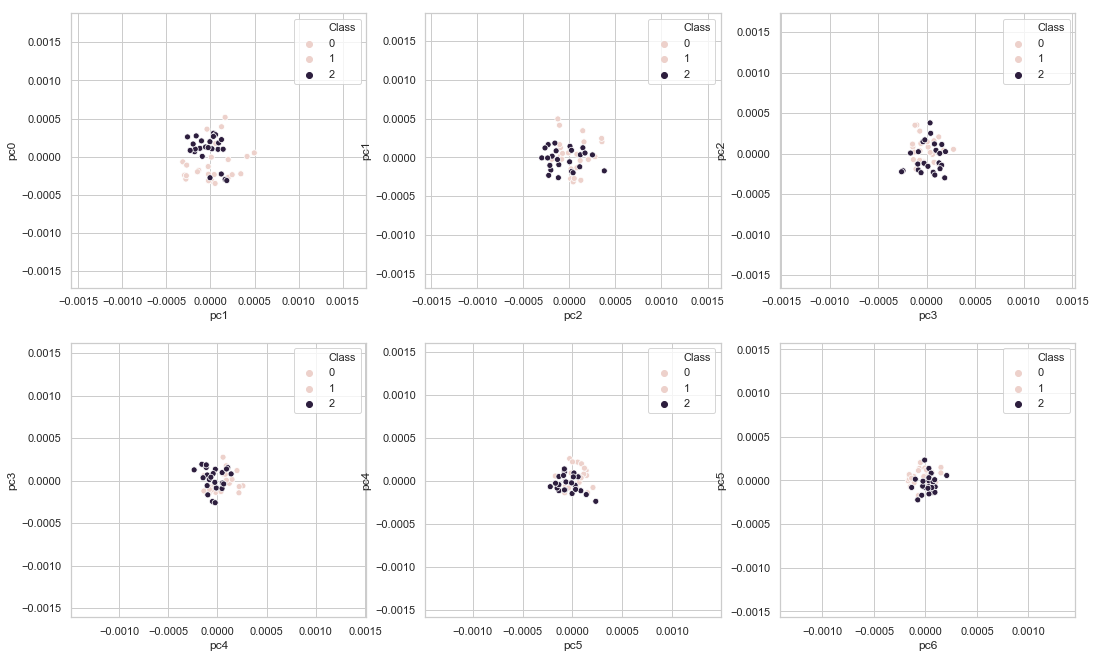

In [26]:
plt.figure(num=None, figsize=(18, 2*len(dataset_pca)))

dataset_int = dataset_pca.copy()
dataset_int['Class'] = dataset_int['Class'].astype(int)

for i in range(dataset_int.shape[1]-2):
    plt.subplot(len(raw)/3,3,i+1)
    g = sns.scatterplot(x='pc'+str(i+1), y='pc'+str(i), hue='Class', data=dataset_int)

## Create model

The last plot above shows that the classes are fairly separated for the first components of the PCA. Besides, all the features are euclidian distances.

For these reasons, the k-Nearest-Neighbors seems a suitable classifier.

Accuracy will be used as the metric since there are only 2 labels.

### Split Dataset

Split dataset between train and test.

In [27]:
target = 'Class'

X = dataset_int.drop(columns={target}).values
y = dataset_int[target].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.5)#, random_state=42)

In [28]:
clf = KNeighborsClassifier(2)
clf.fit(X_train, y_train)

print('Train score: ' + str(round(clf.score(X_train, y_train)*100, 1)), '%')
print('Test score:  ' + str(round(clf.score(X_test, y_test)*100, 1)), '%')

Train score: 95.8 %
Test score:  75.0 %


It looks promising. However, there is overfitting.

The size of the training sample may be a factor with big influence in the overfitting.

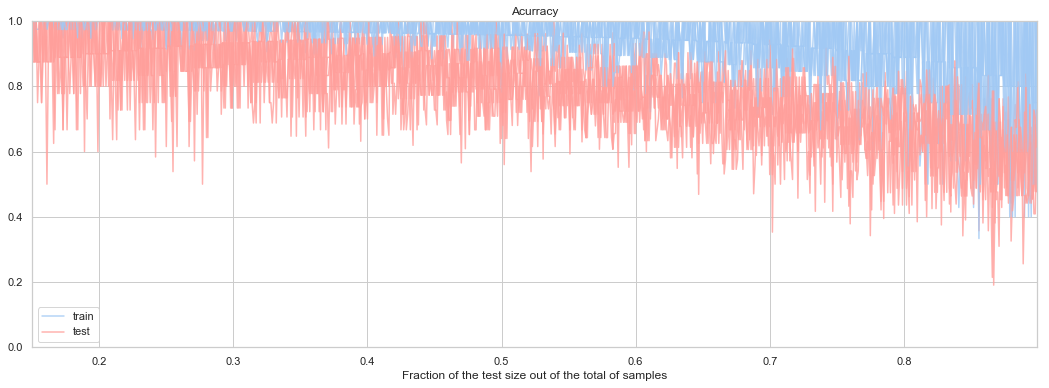

In [29]:
sizes = np.arange(.15, .9, .001)

plt.figure(num=None, figsize=(18, 6))

folds = 5

for i in range(folds):
    scores = []
    
    for size in sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size)

        clf = KNeighborsClassifier(2)
        clf.fit(X_train, y_train)

        scores.append([clf.score(X_train, y_train), clf.score(X_test, y_test)])


    scores_pd = pd.DataFrame(scores)
    scores_pd.columns = ['train', 'test']

    plt.plot(sizes, scores_pd.values[:,0], alpha=0.8, c='b')
    plt.plot(sizes, scores_pd.values[:,1], alpha=0.8, c='r')
    
plt.ylim((0, 1))
plt.xlim((np.min(sizes), np.max(sizes)))
plt.title('Acurracy')
plt.legend(['train', 'test'])
plt.xlabel('Fraction of the test size out of the total of samples')

plt.show()

The size of the train sample is indeed an important parameter. Let us set it to 0.8, which means that the test size is 0.2.

### Optimize Hyperparameters

Now that overfitting is under control we can focus on the other relevant hyperparameters to fine tune our model. 

In [100]:
target = 'Class'

X = dataset_int.drop(columns={target}).values
y = dataset_int[target].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.2)#, random_state=42)

params = {
        'weights': ['uniform', 'distance'],
        'metric' : ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath'],
        }

clf = GridSearchCV(KNeighborsClassifier(2), param_grid=params, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)

print(' best_params = ' + str(clf.best_params_))
print('Train score: ' + str(round(clf.score(X_train, y_train)*100, 1)), '%')
print('Test score:  ' + str(round(clf.score(X_test, y_test)*100, 1)), '%')

 best_params = {'metric': 'euclidean', 'weights': 'distance'}
Train score: 100.0 %
Test score:  90.0 %


It might change the score if we run multiple times because we have not enough samples to train and evaluate. Nonetheless, our final model is performing well. 

### Evaluate Model

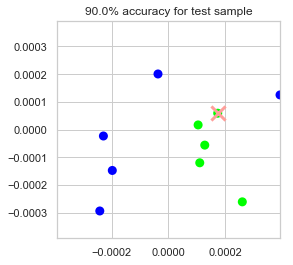

In [101]:
plt.figure(num=None, figsize=(4, 4))

X = X_test
y = y_test
y_pred = clf.predict(X)
limit = np.absolute(X).max()

plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='brg', linewidth=3);

axes = plt.gca()
axes.set_xlim([-limit,limit])
axes.set_ylim([-limit,limit])

misclassifications = y != y_pred
plt.scatter(X[misclassifications, 0], X[misclassifications, 1], s=200, c='r', marker='x', linewidth=3);
score = round((1 - misclassifications.sum()/y_pred.shape[0])*100, 1)
plt.title(str(score) + '% accuracy for test sample')
#plt.legend(['1', '2', '3'])

plt.show()

## Predict Test

### Prepare Test Dataset

In [109]:
path = './Test/'

list_test = []
filenames = []

for i, filename in enumerate(glob.glob(os.path.join(path, '*.npy'))):
    filenames.append(filename.split('\\')[1])
    list_test.append(np.load(filename))

In [103]:
dataset_test = prepare_dataset(list_test)
dataset_test.head()

,300to400_3Hz,700to800_3Hz,700to800_4Hz,1500to1600_4Hz,1600to1700_3Hz,1600to1700_5Hz,1800to1900_4Hz,1800to1900_7Hz,1900to2000_2Hz,1900to2000_5Hz,1800to2000_9Hz,2300to2400_3Hz
0,0.000204,0.000942,0.000233,0.000610,0.000399,0.000128,0.000391,0.000227,0.000201,0.000454,0.000729,0.000359
1,0.000262,0.000488,0.000179,0.000216,0.000210,0.000213,0.000068,0.000047,0.000339,0.000135,0.000160,0.000159
2,0.000048,0.000460,0.000191,0.000137,0.000145,0.000217,0.000065,0.000092,0.000254,0.000143,0.000191,0.000201
3,0.000067,0.000423,0.000145,0.000275,0.000226,0.000130,0.000066,0.000096,0.000436,0.000114,0.000067,0.000223
4,0.000161,0.000393,0.000231,0.000351,0.000320,0.000369,0.000061,0.000058,0.000295,0.000228,0.000289,0.000274


In [104]:
def reduce_dataset(dataset):
    dataset_reduced = pd.DataFrame(pca.transform(dataset.values))
    dataset_reduced.columns = ['pc' + str(col) for col in dataset_reduced.columns.tolist()]
    dataset_reduced = dataset_reduced.drop(columns=['pc7', 'pc8', 'pc9', 'pc10', 'pc11'])
    
    return dataset_reduced

In [105]:
dataset_reduced = reduce_dataset(dataset_test)
dataset_reduced.head()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6
0,0.000172,0.000193,-0.000258,-0.000165,-2.038699e-05,0.000130,-0.000035
1,-0.000634,-0.000172,-0.000082,0.000101,6.749611e-05,0.000208,0.000047
2,-0.000677,-0.000234,-0.000053,-0.000062,1.159095e-04,0.000344,0.000055
3,-0.000656,-0.000217,-0.000090,0.000045,-9.091602e-05,0.000399,0.000137
4,-0.000449,-0.000236,0.000057,0.000014,-7.956665e-07,0.000262,-0.000033


### Apply Predictive Model

In [120]:
y_submit = clf.predict(dataset_reduced)

print('Predictions for test sample are: ')
print()
print('FILENAME                       CLASS')
print()
for i, filename in enumerate(filenames):
    print(filename, ' \t', y_submit[i])

Predictions in test sample are: 

FILENAME                       CLASS

V1-PASSTHROUGH-15-10-51.npy  	 2
V10-PASSTHROUGH-15-10-51.npy  	 1
V11-PASSTHROUGH-15-10-51.npy  	 1
V12-PASSTHROUGH-15-10-51.npy  	 1
V13-PASSTHROUGH-15-10-51.npy  	 1
V14-PASSTHROUGH-15-10-51.npy  	 1
V15-PASSTHROUGH-15-10-51.npy  	 1
V16-PASSTHROUGH-15-10-51.npy  	 1
V2-PASSTHROUGH-15-10-51.npy  	 2
V3-PASSTHROUGH-15-10-51.npy  	 2
V4-PASSTHROUGH-15-10-51.npy  	 2
V5-PASSTHROUGH-15-10-51.npy  	 2
V6-PASSTHROUGH-15-10-51.npy  	 1
V7-PASSTHROUGH-15-10-51.npy  	 1
V8-PASSTHROUGH-15-10-51.npy  	 2
V9-PASSTHROUGH-15-10-51.npy  	 1


Melhorar:
- Abstract
- violin xlabel
- pca legenda
- pca grid
- pca zoom
- overfitting plot region
- legend in misclassifications
- rename df_stuff to list_stuff
- remove comments in code